<a href="https://colab.research.google.com/github/drew-walkerr/Diss_Detecting_Provider_Bias/blob/main/doubt_markers_regex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import os
import re
import sys
import scipy
import Cython
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import English
import numpy as np

from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/gdrive/')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/gdrive/


In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding


In [25]:

%cd /content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Doubt Markers/1_Data Prep
%ls

/content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Doubt Markers/1_Data Prep
 1_doubt_makers_word_embeddings.py
 annotation_Annie_sample_doubt_markers.csv
 annotation_Drew_sample_doubt_markers.csv
 cocode_sample_doubt_markers.csv
 doubt_marker_list_round_3_gpt.csv
 doubt_markers_dataframe_annotate.csv
 doubt_markers_dataframe_annotate.xlsx
 doubt_markers_lexicon_dev.ipynb
 doubt_markers_regex.ipynb
 doubt_word_list_round_1_dw_pruned.csv
 doubt_word_list_round_2.csv
 doubt_words_lexicon_stem_and_similar_round1.csv
 Drew_initial_sample_doubt_markers.csv
 expanded_misspellings.csv
 lexicon_search_and_visualizations_subreddit.Rmd
 reliability_sample_doubt_markers.csv
'Sentiment Score Distribution of Sentences with Matching Doubt Markers.png'
 stigma_word_list_round_3_gpt.csv
'Top 20 Bigrams around Doubt Marker Matches in Charts.png'
'Top 20 Bigrams around Stigmatizing Word Matches in Charts.png'
'Top 20 Matched Terms from Doubt Marker Lexicon.png'
'Top 20 Matched Terms from Stigmat

BigQuery

In [ ]:
#Replace 'project_id' with your BigQuery project ID

from google.cloud import bigquery
client = bigquery.Client(project='detecting-bias-mimic-iii')

icd_query = ('''SELECT *
                FROM physionet-data.mimiciii_clinical.diagnoses_icd
                LIMIT 1000''')

icd = client.query(icd_query).to_dataframe()



ICD codes

In [ ]:


#Filter for ICD codes for 282.60-282.69, referring to sickle cell types w/wo crisis
#2824 for thalassemia w + w/o crisis (282.41-282.42)
#SCD: 2826,2824
#Chronic Pain 3382
#Opioid dependencies: 3040,3047 (combo),
#HIV/AIDS ^042$

icds_of_interest = icd[icd['ICD9_CODE'].str.contains('2826|2824|3040|3047|3382|^042$', na=False)]
# Issues here-- will cause more leading numbers
print(icds_of_interest.head())

icds_of_interest.info()

#patients_unique = icds_of_interest['SUBJECT_ID'].drop_duplicates()


     ROW_ID  SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
784  176454       15872   139593        3     73382
889  196755       17664   123887        7     33829
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 784 to 889
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROW_ID      2 non-null      Int64 
 1   SUBJECT_ID  2 non-null      Int64 
 2   HADM_ID     2 non-null      Int64 
 3   SEQ_NUM     2 non-null      Int64 
 4   ICD9_CODE   2 non-null      object
dtypes: Int64(4), object(1)
memory usage: 104.0+ bytes


Notes and patients load

In [ ]:
note_query = ('''SELECT *
                FROM physionet-data.mimiciii_notes.noteevents''')
                # LIMIT 500000

NOTES = client.query(note_query).to_dataframe()

peek_notes = NOTES.head()
print(peek_notes)

## Patients

patient_query = ('''SELECT *
                FROM physionet-data.mimiciii_clinical.patients''')

PATIENTS = client.query(patient_query).to_dataframe()

peek_patients = PATIENTS.head()
print(peek_patients)

biased_notes_patients_corpus = NOTES.merge(PATIENTS, on = 'SUBJECT_ID')

biased_notes_patients_corpus.info()
# Find unique chart types and decide to limit them
    # Remove Radiology, ECG, Respiratory, Echo notes
biased_notes_patients_corpus_filtered = biased_notes_patients_corpus[biased_notes_patients_corpus["CATEGORY"].str.contains("Radiology|ECG|Respiratory|Echo")==False]
# biased_notes_patients_corpus_filtered.to_csv("biased_notes_patients_corpus_filtered.csv")



    ROW_ID  SUBJECT_ID  HADM_ID   CHARTDATE           CHARTTIME  \
0  1557640       22599   164788  2184-03-10 2184-03-10 04:27:00   
1  1892226       15204   168396  2128-01-25 2128-01-25 05:58:00   
2  1974608       21464   109525  2189-05-13 2189-05-13 10:56:00   
3  1993393       23286   122536  2141-07-14 2141-07-14 11:34:00   
4  1848162       11994   142976  2104-11-04 2104-11-04 06:42:00   

            STORETIME       CATEGORY DESCRIPTION   CGID  ISERROR  \
0 2184-03-10 04:38:00  Nursing/other      Report  14962     <NA>   
1 2128-01-25 06:10:00  Nursing/other      Report  15484     <NA>   
2 2189-05-13 10:58:00  Nursing/other      Report  15444     <NA>   
3 2141-07-14 11:40:00  Nursing/other      Report  14943     <NA>   
4 2104-11-04 06:51:00  Nursing/other      Report  14470     <NA>   

                                                TEXT  
0  csru nursing update\nadditional lopressor iv b...  
1  NPN\n\n\n#2Resp O- Remains in NC 600cc's 70-10...  
2  Neo Attend PE note\n

Explode by sentence, regex quote match

In [ ]:
full_dataframe = biased_notes_patients_corpus_filtered
# Tokenize by sentence
nlp = English()  # just the language with no model

nlp.add_pipe('sentencizer')
full_dataframe["Sentence"] = full_dataframe["TEXT"].apply(lambda x: [sent.text for sent in nlp(x).sents])
full_dataframe = full_dataframe.explode("Sentence", ignore_index=True)
full_dataframe.rename(columns={"Unnamed: 0": "ROW_ID_new"}, inplace=True)
full_dataframe.index.name = "Sentence ID"

full_dataframe['Sentence'].replace(r'\s+|\\n', ' ', regex=True, inplace=True)



<ipython-input-89-1e5fd6deed48>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_dataframe["Sentence"] = full_dataframe["TEXT"].apply(lambda x: [sent.text for sent in nlp(x).sents])


# Regex matching all stemwords + any semantically similar word identified

In [5]:
# Read in sentence tokenized MIMIC-III

full_dataframe = pd.read_csv("/content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/mimic_iii_sentence_tokenized.csv")



ParserError: ignored

In [ ]:
doubt_word_list = pd.read_csv("doubt_marker_list_round_3_gpt.csv")
doubt_word_list
# Define the list of words to filter out -- too much noise in medical notes
words = ['suspicion', 'suspicious', 'questionable', 'questioning', 'uncertain', 'hesitancy', 'hesitant','unsure']

doubt_word_list['similar_word'] = doubt_word_list['similar_word'].str.strip()

# Filter the dataframe
doubt_word_list_pruned = doubt_word_list[~doubt_word_list['similar_word'].isin(words)]
doubt_word_list_pruned

# Create regex which is each stem word + all similar_words identified in the word embeddings step, which will be used to search the charts
def group_and_create_regex(dataframe):
    grouped_data = dataframe.groupby('stem_word')['similar_word'].apply(list).reset_index()
    grouped_data['regex'] = grouped_data.apply(lambda row: '|'.join([re.escape(row['stem_word'])] + [re.escape(word) for word in row['similar_word']]), axis=1)
    return grouped_data

grouped_data = group_and_create_regex(doubt_word_list_pruned)
print(grouped_data)

# Create function that takes regex from each row and searches the charts
def identify_matching_strings(full_dataframe, grouped_data):
    matching_dataframes = []

    for index, row in grouped_data.iterrows():
        regex = row['regex']
        terms = row['similar_word']
        for term in terms:
            term = r"\b" + re.escape(term) + r"\b"  # Adding word boundaries
            matches = full_dataframe.loc[full_dataframe['Sentence'].str.contains(term, flags=re.IGNORECASE, na=False)].copy()
            matches['regex'] = regex
            matches['matched_term'] = term  # Add the matched term as a new column
            matching_dataframes.append(matches)

    first_dataframe = pd.concat(matching_dataframes)
    print(f"Size before patient related filter: {first_dataframe.shape[0]}")  # Print the size before filter

    final_dataframe = first_dataframe.loc[first_dataframe['Sentence'].str.contains(r'\b(?:pt|patient|pateint)\b', flags=re.IGNORECASE, na=False)].copy()  # Add condition here

    print(f"Final size after patient related filter: {final_dataframe.shape[0]}")  # Print the size after filter

    return first_dataframe

# For doubt markers, we actually found

small_dataframe = full_dataframe.head(100000)


result = identify_matching_strings(full_dataframe, grouped_data)
result




In [ ]:

quoted_dataframe = result

quoted_dataframe["doubt_testimony"] = ""
quoted_dataframe["annotator_comments"] = ""
# 1459 matching sentences from total of 9,118,501 sentences from 366,002 charts
# 4,418 unique sentences from total of 30,582,959 sentences from 1,274,317 charts
quoted_dataframe2 = quoted_dataframe.drop_duplicates(subset=['Sentence'])
quoted_dataframe2.to_excel("doubt_markers_dataframe_annotate.xlsx", index = False)



# Annotation data sample

In [26]:
# Create the annotation samples
#!pip install pandas openpyxl
%ls
old_df_before_unsure = pd.read_csv("doubt_markers_dataframe_annotate.csv")
quoted_dataframe2 = pd.read_excel("doubt_markers_dataframe_annotate.xlsx")

# Filter the dataframe

np.random.seed(23)
# List of tuples (sample size, dataframe name)
sample_params = [(50, 'Drew_initial'), (5, 'cocode'), (100, 'reliability'), (400, 'annotation_Annie'), (500, 'annotation_Drew')]

# Dictionary to hold the dataframes
dfs = {}

for size, name in sample_params:
    # Random sample without replacement
    sample_df = quoted_dataframe2.sample(n=size, replace=False)

    # Add the sample to the dictionary
    dfs[name] = sample_df

    # Remove the sampled rows from the original dataframe
    quoted_dataframe2 = quoted_dataframe2.drop(sample_df.index)

%cd /content/gdrive/MyDrive/Diss_Detecting_Provider_Bias/Aim 1/Doubt Markers/2_Annotation

# Now you can access each dataframe using their names.
# For example, to access the 'Drew' dataframe:
drew_df = dfs['Drew_initial']
drew_df
drew_df.to_excel("Drew_initial_sample_doubt_markers.xlsx",index = False)

cocode_df = dfs['cocode']
cocode_df
cocode_df.to_excel("cocode_sample_doubt_markers.xlsx",index = False)

reliability_df = dfs['reliability']
reliability_df
reliability_df.to_excel("reliability_sample_doubt_markers.xlsx",index = False)

annotation_Annie_df = dfs['annotation_Annie']
annotation_Annie_df
annotation_Annie_df.to_excel("annotation_Annie_sample_doubt_markers.xlsx",index = False)

annotation_Drew_df = dfs['annotation_Drew']
annotation_Drew_df
annotation_Drew_df.to_excel("annotation_Drew_sample_doubt_markers.xlsx",index = False)


## Sentiment analysis of doubt markers word list


In [ ]:
!pip install transformers
from transformers import pipeline

# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Get both the sentiment and score in one apply function
doubt_word_list_pruned['sentiment_result'] = doubt_word_list_pruned['similar_word'].apply(lambda x: (sentiment_pipeline(x)[0]['label'], sentiment_pipeline(x)[0]['score']))

# Split the result into two separate columns
doubt_word_list_pruned[['sentiment', 'sentiment_score']] = pd.DataFrame(doubt_word_list_pruned['sentiment_result'].tolist(), index=doubt_word_list_pruned.index)

# You can drop the 'sentiment_result' column afterwards if it's not needed
doubt_word_list_pruned = doubt_word_list_pruned.drop(columns=['sentiment_result'])
doubt_word_list_pruned

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


NameError: ignored

## Top Terms in Doubt Markers Data

In [32]:
import pandas as pd
import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import string
import re

# Load the stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
quoted_dataframe2['matched_term'] = quoted_dataframe2['matched_term'].str.replace(r'\\b', '')

def preprocess(sentence, term, window_size=20):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    tokens = sentence.split()
    try:
        term_index = tokens.index(term)
        return tokens[max(0, term_index - window_size) : min(term_index + window_size + 1, len(tokens))]
    except ValueError:
        return []
    except IndexError:
        return []

# Apply preprocessing and tokenization
quoted_dataframe2['Tokenized'] = quoted_dataframe2.apply(lambda row: preprocess(row['Sentence'], row['matched_term']), axis=1)

# Remove rows with empty 'Tokenized' lists


# Apply preprocessing and tokenization
quoted_dataframe2['Tokenized'] = quoted_dataframe2.apply(lambda row: preprocess(row['Sentence'], row['matched_term']), axis=1)


# Flatten the list of words in Tokenized column
words = [word for sublist in quoted_dataframe2['Tokenized'].tolist() for word in sublist]

# Remove stopwords
filtered_words = [word for word in words if word not in stop_words]

# Generate bigrams and trigrams
bigram_list = list(bigrams(words))
trigram_list = list(trigrams(words))

# Get the frequency of each word, bigram, and trigram
filtered_word_freq = Counter(filtered_words)
bigram_freq = Counter(bigram_list)
trigram_freq = Counter(trigram_list)

# Get top 20 most common words, bigrams, and trigrams
top20_filtered_words = filtered_word_freq.most_common(20)
top20_bigrams = bigram_freq.most_common(20)
top20_trigrams = trigram_freq.most_common(20)

# Function to create count horizontal bar chat
def plot_most_common(n_most_common, title):
    items, counts = zip(*n_most_common)
    plt.figure(figsize=(10, 7))
    plt.barh(range(len(items)), counts, color='skyblue')
    plt.yticks(range(len(items)), items)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
    plt.show()

# Plot top 20 most common words, bigrams, and trigrams
plot_most_common(top20_filtered_words, 'Top 20 Words around Doubt Marker Matches in Charts')
plot_most_common(top20_bigrams, 'Top 20 Bigrams around Doubt Marker Matches in Charts')
plot_most_common(top20_trigrams, 'Top 20 Trigrams around Doubt Marker Matches in Charts')

# Get the frequency of each matched term
matched_term_freq = Counter(quoted_dataframe2['matched_term'])

# Get top 20 most common matched terms
top20_matched_terms = matched_term_freq.most_common(20)

# Plot top 20 most common matched terms
plot_most_common(top20_matched_terms, 'Top 20 Matched Terms from Doubt Marker Lexicon')

# make counter df
matched_term_freq_df = pd.DataFrame(matched_term_freq.items(), columns=['matched_term', 'frequency'])

doubt_word_list_pruned_clean = doubt_word_list_pruned.rename(columns={"similar_word": "matched_term"})
doubt_word_sna_df = pd.merge(doubt_word_list_pruned_clean, matched_term_freq_df, on="matched_term", how="left")
doubt_word_sna_df['frequency'] = doubt_word_sna_df['frequency'].fillna(0)

doubt_word_sna_df.to_csv("doubt_word_sna_df.csv")



# Token lengths

In [ ]:
# Define a function to count words in a sentence
def word_count(sentence):
    return len(sentence.split())

# Calculate word count for each row of the 'Sentence' and 'TEXT' columns
quoted_dataframe2['Sentence_word_count'] = quoted_dataframe2['Sentence'].apply(word_count)
quoted_dataframe2['TEXT_word_count'] = quoted_dataframe2['TEXT'].apply(word_count)

# Calculate the mean, median, and standard deviation of word counts
sentence_mean = quoted_dataframe2['Sentence_word_count'].mean()
sentence_median = quoted_dataframe2['Sentence_word_count'].median()
sentence_std = quoted_dataframe2['Sentence_word_count'].std()

text_mean = quoted_dataframe2['TEXT_word_count'].mean()
text_median = quoted_dataframe2['TEXT_word_count'].median()
text_std = quoted_dataframe2['TEXT_word_count'].std()

print("Sentence word count - Mean: {}, Median: {}, Std: {}".format(sentence_mean, sentence_median, sentence_std))
print("Each Narrative entry word count - Mean: {}, Median: {}, Std: {}".format(text_mean, text_median, text_std))


Sentence word count - Mean: 35.01945080091533, Median: 21.0, Std: 63.970843420619815
Each Narrative entry word count - Mean: 936.9016018306636, Median: 485.0, Std: 965.1303026994467


## All stigmatizing sentences sentiment

In [ ]:
from transformers import AutoTokenizer, pipeline

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
sentiment_pipeline = pipeline("sentiment-analysis")

def apply_sentiment(sentence):
    # Tokenize the sentence and truncate to 256 tokens
    tokens = tokenizer.tokenize(sentence)[:256]
    # Rejoin the tokens into a truncated sentence
    truncated_sentence = ' '.join(tokens)
    # Apply the sentiment pipeline
    result = sentiment_pipeline(truncated_sentence)[0]
    return result['label'], result['score']
quoted_sentiment = quoted_dataframe2
# Get both the sentiment and score in one apply function
quoted_sentiment['sentiment_result'] = quoted_dataframe2['Sentence'].apply(apply_sentiment)

# Split the result into two separate columns
quoted_dataframe2[['sentiment', 'sentiment_score']] = pd.DataFrame(quoted_dataframe2['sentiment_result'].tolist(), index=quoted_dataframe2.index)

# You can drop the 'sentiment_result' column afterwards if it's not needed
quoted_dataframe2 = quoted_dataframe2.drop(columns=['sentiment_result'])


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Token indices sequence length is longer than the specified maximum sequence length for this model (1095 > 512). Running this sequence through the model will result in indexing errors


## Sentiment visualization


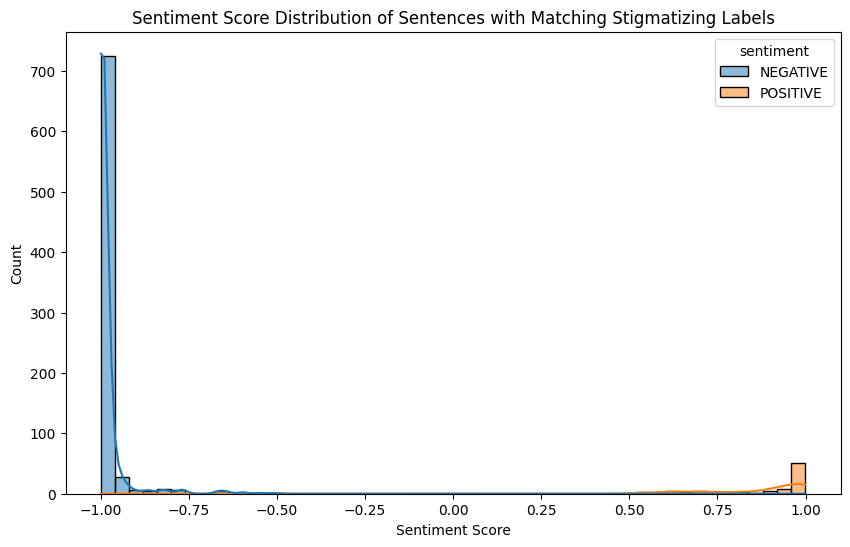

In [ ]:
quoted_dataframe2['sentiment_score_signed'] = quoted_dataframe2.apply(lambda row: -row['sentiment_score'] if row['sentiment'] == 'NEGATIVE' else row['sentiment_score'], axis=1)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(data=quoted_dataframe2, x="sentiment_score_signed", hue="sentiment", bins=50, kde=True)
plt.title('Sentiment Score Distribution of Sentences with Matching Stigmatizing Labels')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.savefig("Sentiment Score Distribution of Sentences with Matching Doubt Markers.png", bbox_inches='tight', dpi=300)
plt.show()



## Most positive, negative, and neutral sentences

In [ ]:
# Top 10 positive sentences
top_positive = quoted_dataframe2[quoted_dataframe2['sentiment'] == 'POSITIVE'].nlargest(10, 'sentiment_score_signed')[['Sentence', 'sentiment_score_signed','matched_term']]
print("Top 10 Positive Sentences:")
print(top_positive)

# Top 10 negative sentences
top_negative = quoted_dataframe2[quoted_dataframe2['sentiment'] == 'NEGATIVE'].nsmallest(10, 'sentiment_score_signed')[['Sentence', 'sentiment_score_signed','matched_term']]
print("\nTop 10 Negative Sentences:")
print(top_negative)

# Top 10 neutral sentences
quoted_dataframe2['abs_sentiment_score'] = quoted_dataframe2['sentiment_score_signed'].abs()
top_neutral = quoted_dataframe2.nsmallest(10, 'abs_sentiment_score')[['Sentence', 'abs_sentiment_score','matched_term']]
print("\nTop 10 Neutral Sentences:")
print(top_neutral)


Top 10 Positive Sentences:
                                               Sentence  \
1076  Has positive outlook, believes she will be abl...   
1285   She shares that she is a woman of deep faith ...   
1039       His wife confirms she believes this is true.   
1903   Nephew believes that this level of independen...   
1442   As she had a positive NICU experience before,...   
1279   Sister reports that she is feeling more hopef...   
1276   He plans to continue these supports upon d/c ...   
1281   He states he believes daughters are doing wel...   
1435  Psych aware of his decision to leave and belie...   
1252   Her son clearly understands all these issues ...   

      sentiment_score_signed matched_term  
1076                0.999740     believes  
1285                0.999456     believes  
1039                0.999433     believes  
1903                0.999286     believes  
1442                0.999229     believes  
1279                0.999025     believes  
1276           